In [2]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from seaborn import barplot
from seaborn import distplot
from seaborn import lmplot

## В данном примере используются первые 20 млн записей. Анализ по всем записям находится в отдельных notebook-ах.

In [3]:
df = pd.read_csv('final_df.csv', nrows = 20000000)

### Преобразуем timestamp в дату

In [4]:
df['event_time']  = pd.to_datetime(df['event_time'], unit='s')
df['event_time'] = df['event_time'].apply(lambda x: x.date())
df.columns = ['user_id', 'action', 'level', 'date']

In [5]:
df.head()

,user_id,action,level,date
0,0,0,83,2016-01-18
1,1,0,29,2016-01-18
2,2,0,24,2016-01-18
3,3,1,2,2016-01-18
4,4,0,35,2016-01-18


### Посчитаем кол-во уникальных user_id  (~uid) по дням

In [6]:
users_per_day = pd.DataFrame(df.groupby('date')['user_id'].nunique())
users_per_day.head()

,user_id
date,
2016-01-14,63031
2016-01-15,118244
2016-01-16,172236
2016-01-17,38958
2016-01-18,72021


### Построим график и рассчитаем метрику DAU (медиану и среднее за рассматриваемый период)

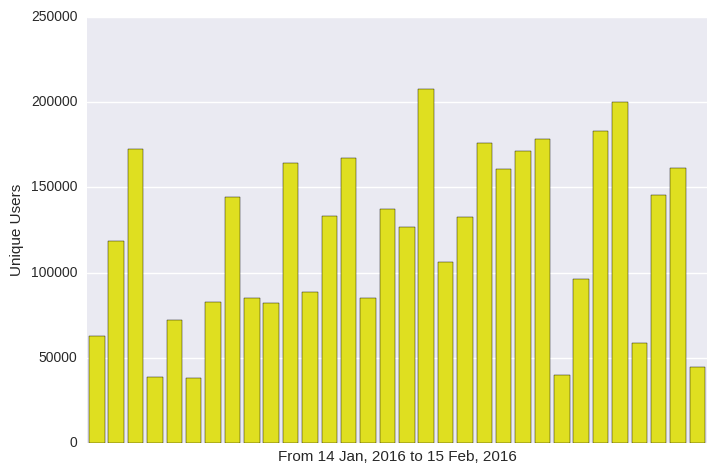

DAU (median) =  129471
DAU (mean) =  120667


In [7]:
ax = barplot(users_per_day.index, users_per_day['user_id'], color="yellow")
x_label = 'From ' + str(users_per_day.index.min().strftime('%d %b, %Y')) + ' to ' + str(users_per_day.index.max().strftime('%d %b, %Y'))
y_label = 'Unique Users'
ax.set(xlabel = x_label, ylabel = y_label)
ax.tick_params(labelbottom='off')
plt.show()

median_DAU = round(users_per_day['user_id'].median())
mean_DAU = round(users_per_day['user_id'].mean())
print('{0} {1}'.format('DAU (median) = ', median_DAU))
print('{0} {1}'.format('DAU (mean) = ', mean_DAU))

### Определим максимальный уровень, который прошёл пользователь

In [8]:
user_lvl = pd.DataFrame(df[df['action'] == 1].groupby(['user_id'])['level'].max())
user_lvl.head()

,level
user_id,
0,128
1,76
2,29
3,31
4,93


### Построим распределение пользователей по уровням

/home/adam/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


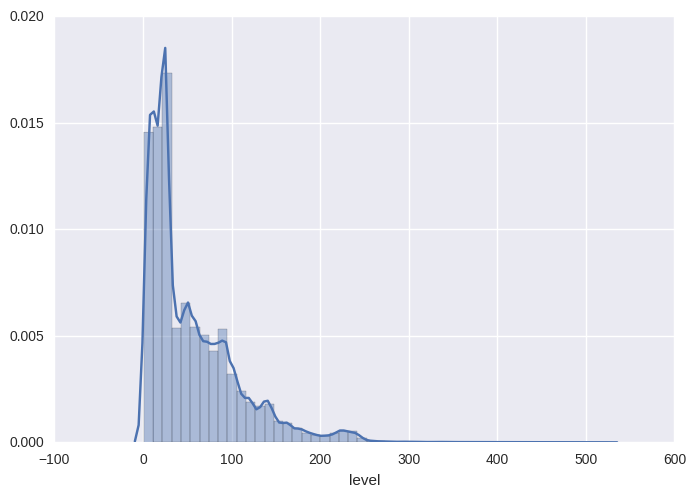

In [9]:
distplot(user_lvl['level'], kde=True)
plt.show()

### Рассчитаем статистики по игрокам и уровням

In [10]:
tries_per_user_and_level = pd.DataFrame(df.groupby(['user_id', 'level'], as_index = False)['action'].agg(['sum', 'count']))
tries_per_user_and_level.reset_index(inplace = True)
tries_per_user_and_level.columns = ['user_id','level','is_passed','total_tries']
tries_per_user_and_level['fails'] = tries_per_user_and_level['total_tries'] - tries_per_user_and_level['is_passed']
tries_per_user_and_level.head()

,user_id,level,is_passed,total_tries,fails
0,0,64,0,5,5
1,0,72,1,1,0
2,0,73,0,1,1
3,0,75,1,3,2
4,0,76,0,3,3


### Рассчитаем показатель pass_ration, равный отношению кол-ва игроков прошедших уровень к кол-ву игроков как минимум 1 раз просматревшим уровень.

In [11]:
pass_ration_per_lvl = pd.DataFrame(
    tries_per_user_and_level.groupby('level', as_index = False)['is_passed'].agg(['sum', 'count']))
pass_ration_per_lvl.reset_index(inplace = True)
pass_ration_per_lvl['pass_ratio'] = pass_ration_per_lvl['sum'] / pass_ration_per_lvl['count']

# земеним нулевую pass_ratio на минимальную
pass_ration_per_lvl.loc[pass_ration_per_lvl['pass_ratio'] == 0, 'pass_ratio'] = pass_ration_per_lvl.loc[pass_ration_per_lvl['pass_ratio'] != 0, 'pass_ratio'].min()
pass_ration_per_lvl.head()

,level,sum,count,pass_ratio
0,1,86735,87523,0.990997
1,2,82578,84670,0.975292
2,3,79788,82093,0.971922
3,4,77890,78659,0.990224
4,5,75298,79344,0.949007


### Рассчитаем сколько попыток потребовалось пользователям для того, чтобы пройти уровень (среднее и медиана)

In [12]:
tries_per_user_and_levels_passed = tries_per_user_and_level[tries_per_user_and_level['is_passed'] == 1]

tries_per_level = pd.DataFrame(
    tries_per_user_and_levels_passed.groupby('level', as_index = False)['fails'].agg(['mean', 'median']))
tries_per_level.reset_index(inplace = True)
tries_per_level.loc[tries_per_level['median'] == 0,'median'] = 0.5
tries_per_level.sort_values('mean', ascending = False).head(5)

,level,mean,median
146,147,9.119156,5.5
234,235,8.576321,3.0
94,95,7.912617,5.0
233,234,7.202317,4.0
179,180,7.192917,4.0


### В коэф. сложности желательно включить  все признаки, которые могут так или иначе характерировать степень сложности уровня. Для этого был выбран следующий показатель: "difficulty" = корень("средн. кол-во попыток на уровень"  *  "медианное. кол-во попыток на уровень")  /  "доля пользователей, прошедших уровень".

In [13]:
tries_per_level = tries_per_level.merge(pass_ration_per_lvl[['level', 'pass_ratio']], how = 'outer', on = 'level')
tries_per_level['difficulty'] = (tries_per_level['mean'] * tries_per_level['median'])**0.5 / tries_per_level['pass_ratio']
tries_per_level.sort_values('difficulty', ascending = False).head()

,level,mean,median,pass_ratio,difficulty
146,147,9.119156,5.5,0.171834,41.214546
94,95,7.912617,5.0,0.160708,39.138821
103,104,6.654697,4.0,0.179607,28.725664
142,143,7.059526,4.0,0.187773,28.299894
179,180,7.192917,4.0,0.204057,26.286345


### Можно заметить, что с уровнями в среднем пользователи становятся более вовлеченными в игру и с большей вероятность пройдут следующий уровень

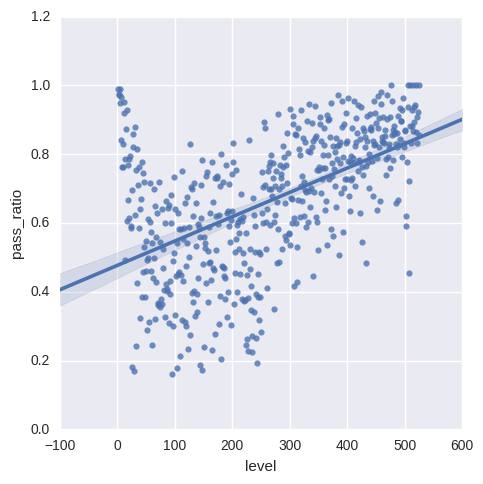

In [14]:
lmplot('level','pass_ratio',pass_ration_per_lvl,sharex=False,sharey=False)

### Можно заметить, что чем больше попыток игроку приходится препринимать, чтобы пройти игру, тем вероятнее он не пройдёт этот уровень. И как следствие перестанен играть.

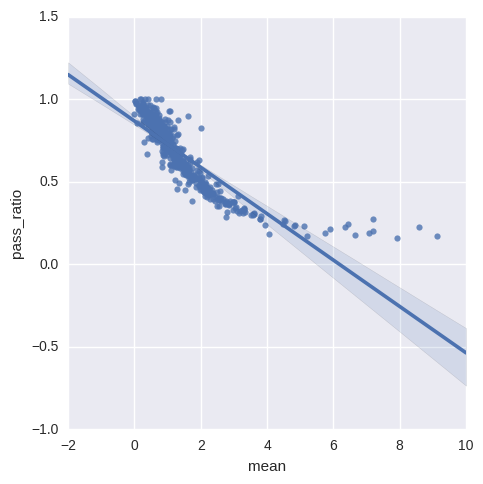

In [15]:
lmplot('mean','pass_ratio',tries_per_level,sharex=False,sharey=False)